# Pré-processamento e criação do modelo

Nesta etapa do projeto utilizaremos das informações coletadas na etapa de EDA para tratarmos nossas features visando uma melhor aplicação ao modelo. Trazendo nossos resultados do EDA, temos:

- Exclusão das variáveis `score_8`, `produto` e `score_fraude_modelo` 
- Há variáveis discretas dentre as numéricas
- Podemos aplicar a transformação log nas variávels `score_3` e `valor_compra`
- Podemos aplicar a transformação cúbica ao `score_6`
- A variável `pais` pode ser agrupada em continentes
- Podemos transformar a variável `data_compra` em hora do dia e dia da semana.

In [1]:
import os
import pandas as pd


import numpy as np


from tabulate import tabulate

import mlflow
import mlflow.sklearn
from urllib.parse import urlparse


from sklearn.model_selection import (
    train_test_split,
    KFold,
    cross_val_score,
    RandomizedSearchCV,
)


import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.ensemble import RandomForestClassifier


from sklearn.tree import DecisionTreeClassifier


from xgboost import XGBClassifier


from lightgbm import LGBMClassifier


from sklearn.metrics import (
    roc_auc_score,
    log_loss,
    precision_score,
    recall_score,
    f1_score,
)


from sklearn.base import BaseEstimator, TransformerMixin


from sklearn.pipeline import Pipeline


from sklearn.impute import SimpleImputer


from sklearn.preprocessing import TargetEncoder


from sklearn.compose import ColumnTransformer


import pycountry_convert as pc


import warnings


warnings.simplefilter(action="ignore", category=FutureWarning)

Vamos carregar e consultar novamente nossos dados, isso servirá como um parâmetro para como está o estado das variáveis e como queremos transformá-las. Lembrando para aplicarmos nossos dados de amostra a um modelo, precisamos que todas as variáveis estejam com valor numérico, isso permite aplicá-las a determinados modelos.

In [2]:
df = pd.read_csv("../artifacts/data_ingestion/dados.csv")
df.head()

,score_1,score_2,score_3,score_4,score_5,score_6,pais,score_7,produto,categoria_produto,score_8,score_9,score_10,entrega_doc_1,entrega_doc_2,entrega_doc_3,data_compra,valor_compra,score_fraude_modelo,fraude
0,4,0.7685,94436.24,20.0,0.444828,1.0,BR,5,Máquininha Corta Barba Cabelo Peito Perna Pelo...,cat_8d714cd,0.883598,240.0,102.0,1,NaN,N,2020-03-27 11:51:16,5.64,66,0
1,4,0.7550,9258.50,1.0,0.000000,33.0,BR,0,Avental Descartavel Manga Longa - 50 Un. Tnt ...,cat_64b574b,0.376019,4008.0,0.0,1,Y,N,2020-04-15 19:58:08,124.71,72,0
2,4,0.7455,242549.09,3.0,0.000000,19.0,AR,23,Bicicleta Mountain Fire Bird Rodado 29 Alumini...,cat_e9110c5,0.516368,1779.0,77.0,1,NaN,N,2020-03-25 18:13:38,339.32,95,0
3,4,0.7631,18923.90,50.0,0.482385,18.0,BR,23,Caneta Delineador Carimbo Olho Gatinho Longo 2...,cat_d06e653,0.154036,1704.0,1147.0,1,NaN,Y,2020-04-16 16:03:10,3.54,2,0
4,2,0.7315,5728.68,15.0,0.000000,1.0,BR,2,Resident Evil Operation Raccoon City Ps3,cat_6c4cfdc,0.855798,1025.0,150.0,1,NaN,N,2020-04-02 10:24:45,3.53,76,0


Antes de qualquer processamento a ser aplicado a nossos dados devemos dividi-los em treino e teste para evitar vazamento de dados, ou seja nossos dados de teste não devem ser utilizados em treino, garantindo possamos avaliar modelo se o modelo se adapta a dados externos e variados.

In [3]:
X = df.drop("fraude", axis=1)
y = df["fraude"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### Pipelines de pré-processamento

Iremos construir as etapas de pré processamento como classes para serem aplicadas a um Pipeline, criamos uma `CustomClass` para carregar a herança do `BaseEstimator` e `TransformerMixin` para outros componentes, além da inicialização com a designação de colunas.

In [4]:
class CustomProcessor(BaseEstimator, TransformerMixin):
    def __init__(self, cols=[]):
        self.cols = cols

    def fit(self, X, y=None):
        return self

In [5]:
# Processador para retirar colunas desejadas.
class DropColumn(CustomProcessor):

    def transform(self, X):

        return X.drop(self.cols, axis=1)

Vamos processar as colunas de documentos, os valores nulos serão preeenchidos com "N" transforma os valores de texto para 0 ou 1 (N ou Y).

In [6]:
class DocumentsProcessor(CustomProcessor):

    def transform(self, X):

        X_new = X.copy()

        X_new[self.cols] = X_new[self.cols].fillna("N")

        X_new[self.cols] = (X_new[self.cols] == "Y").astype(int)

        return X_new

O processador de datas, vamos criar as colunas de hora e dia da semana. Importante retirarmos a coluna inicial data_compra para evitar informações repetidas.

In [7]:
class DateProcessor(CustomProcessor):

    def transform(self, X):
        X_new = X.copy()
        date = pd.to_datetime(X_new["data_compra"])

        X_new["hora_compra"] = date.dt.hour
        X_new["dia_compra"] = date.dt.dayofweek

        X_new = X_new.drop("data_compra", axis=1)

        return X_new

Para variáveis categóricas vamos aplicar o OneHotEncoding para variáveis com menor cardinalidade.

In [8]:
class OneHotEncoderProcessor(CustomProcessor):

    def transform(self, X):
        X_encoded = pd.get_dummies(X, columns=self.cols, drop_first=True, dtype=int)

        return X_encoded

A classe `ImputeValuesProcessor` é a de maior complexidade devido a necessidade de processar variáveis discretas e contínuas, e aplicá-las ao `ColumnTransformer`. Esta abordagem foi escolhida pois as transformações de saída do `ColumnTransformer` transforma o DataFrame em um array Numpy sem as informações de rótulos de colunas.

Precisamos resgatar os nomes de colunas e transformar novamente em um DataFrame para aplicá-los ao pipeline de transformação.

Para o preenchimento de valores vazios iremos utilizar a média para variáveis contínuas e a moda para variáveis discretas.


In [9]:
class ImputeValuesProcessor(BaseEstimator, TransformerMixin):

    def __init__(self, discrete_cols=[], continuous_cols=[]):
        self.discrete_cols = discrete_cols
        self.continuous_cols = continuous_cols

        self.numerical_imputer = ColumnTransformer(
            transformers=[
                (
                    "discrete",
                    SimpleImputer(strategy="most_frequent"),
                    self.discrete_cols,
                ),
                ("continuous", SimpleImputer(strategy="mean"), self.continuous_cols),
            ],
            remainder="passthrough",
        )

    def fit(self, X, y=None):

        self.numerical_imputer.fit(X)
        return self

    def transform(self, X):

        X_transformed = self.numerical_imputer.transform(X)

        X_transformed = pd.DataFrame(X_transformed, columns=self._get_column_names(X))

        return X_transformed

    def _get_column_names(self, X):

        transformed_columns = (
            self.discrete_cols
            + self.continuous_cols
            + [
                col
                for col in X.columns
                if col not in self.discrete_cols + self.continuous_cols
            ]
        )
        return transformed_columns

Aqui iremos aplicar as transformações numéricas as colunas possívels, sendo a transformação log e raiz cúbica.

In [10]:
class TransformColumns(CustomProcessor):
    def transform(self, X):
        X_new = X.copy()

        print(X_new["valor_compra"].dtype)
        X_new["log_score_3"] = np.log1p(X_new["score_3"].astype(float))
        X_new["log_valor_compra"] = np.log1p(X_new["valor_compra"].astype(float))
        X_new["cbrt_score_6"] = np.cbrt(X_new["score_6"].astype(float))

        X_new = X_new.drop(["score_3", "valor_compra", "score_6"], axis=1)

        return X_new

O processador de país irá transformar a coluna em continentes, agrupando em apenas 5 categorias.

In [11]:
class CountryProcessor(CustomProcessor):
    def transform(self, X):
        X_new = X.copy()
        X_new["pais"] = X_new["pais"].fillna(X_new["pais"].mode()[0])

        X_new["continente"] = X_new["pais"].apply(
            lambda x: pc.country_alpha2_to_continent_code(x)
        )

        X_new = X_new.drop("pais", axis=1)

        return X_new

In [12]:
discrete_columns = ["score_4", "score_7"]
continuous_columns = [
    "score_2",
    "score_3",
    "score_5",
    "score_6",
    "score_9",
    "score_10",
    "valor_compra",
]

to_drop_columns = ["score_fraude_modelo", "produto", "score_8"]

documents_columns = ["entrega_doc_1", "entrega_doc_2", "entrega_doc_3"]


pipeline = Pipeline(
    [
        ("dropper", DropColumn(to_drop_columns)),
        (
            "imputer",
            ImputeValuesProcessor(
                discrete_cols=discrete_columns, continuous_cols=continuous_columns
            ),
        ),
        ("docs", DocumentsProcessor(documents_columns)),
        ("country", CountryProcessor()),
        ("date", DateProcessor()),
        ("encoder", OneHotEncoderProcessor(["score_1", "continente"])),
        ("transform", TransformColumns()),
    ]
)

Após o pipeline de transformação inicial, devemos por último aplicar o TargetEncoding para colunas categóricas de muita categorias (alta cardinalidade) como a coluna `categoria_produto`.

Devemos utilizar os dados de treino para fazer o fit do TargetEncoding para apenas transformarmos os dados de teste.

In [13]:
X_train_t = pipeline.fit_transform(X_train)
X_test_t = pipeline.transform(X_test)

category_train_df = X_train_t["categoria_produto"].to_frame(name="categoria_produto")
category_test_df = X_test_t["categoria_produto"].to_frame(name="categoria_produto")


target_encoder = TargetEncoder(random_state=42)

X_train_t["categoria_produto"] = target_encoder.fit_transform(
    category_train_df, y_train
)
X_test_t["categoria_produto"] = target_encoder.transform(category_test_df)

object
object


Por último realizamos as últimas conversões as colunas que foram transformadas para garantirmos que sejam numéricas.

In [14]:
def convert_to_numeric(df):
    new_df = df.copy()
    for col in new_df.select_dtypes(include=["object"]).columns:
        try:
            new_df[col] = pd.to_numeric(new_df[col], errors="coerce")
        except ValueError as e:
            print(e)
            pass

    return new_df


X_train_t = convert_to_numeric(X_train_t)
X_test_t = convert_to_numeric(X_test_t)

Verificamos que todas as colunas foram alteradas e transformadas para valores numericos a seguir.

In [15]:
X_train_t.dtypes

score_4              float64
score_7              float64
score_2              float64
score_5              float64
score_9              float64
score_10             float64
categoria_produto    float64
entrega_doc_1          int32
entrega_doc_2          int32
entrega_doc_3          int32
hora_compra            int32
dia_compra             int32
score_1_2              int32
score_1_3              int32
score_1_4              int32
continente_AS          int32
continente_EU          int32
continente_NA          int32
continente_OC          int32
continente_SA          int32
log_score_3          float64
log_valor_compra     float64
cbrt_score_6         float64
dtype: object

### Treinamento de modelos

Foram escolhidos modelos de classificação que funcionam baseando-se em árvores de decisão. Fizemos uma comparação entre os seguintes modelos:
- Random Forest
- XGBoost
- LightGBM
- DecisionTree

Tendo em vista que estamos lidando com dados desbalanceados, designamos hiperparâmetros dos modelos para lidar com essa problemática no conjunto de dados. 

In [16]:
models = [
    ("Random Forest", RandomForestClassifier(n_estimators=100, random_state=42)),
    ("XGBoost", XGBClassifier(scale_pos_weight=20, random_state=42)),
    ("LightGBM", LGBMClassifier(class_weight="balanced", random_state=42)),
    ("Decision Tree", DecisionTreeClassifier(class_weight="balanced", random_state=42)),
]

results = []
for name, model in models:
    kfold = KFold(n_splits=4, random_state=42, shuffle=True)
    cv_results = cross_val_score(model, X_train_t, y_train, cv=kfold, scoring="roc_auc")

    recall_results = cross_val_score(
        model, X_train_t, y_train, cv=kfold, scoring="recall"
    )

    results.append(cv_results)
    msg = "%s: %f (%f)" % (
        name,
        cv_results.mean(),
        cv_results.std(),
    )
    print(msg)
    print(recall_results)

Random Forest: 0.772283 (0.000600)
[0.06894288 0.08642809 0.08226568 0.06842818]
XGBoost: 0.757314 (0.007698)
[0.52330926 0.52329507 0.50505732 0.50745257]
[LightGBM] [Info] Number of positive: 4440, number of negative: 85560
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004836 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2197
[LightGBM] [Info] Number of data points in the train set: 90000, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 4482, number of negative: 85518
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003157 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=

A métrica utilizada de comparação foi a de Área sob a curva (ROC AUC). Os modelos que obtiveram o melhor desempenho foram `LightGBM` e `RandomForest`, enquanto o pior desempenho foi obtido pela `Decision Tree`.

Por razões de eficiência, desempenho e possibilidade de escalabilidade para conjuntos maiores, iremos prosseguir os experimentos com o modelo `LightGBM`. Onde iremos realizar uma busca de melhor hiperparâmetros utilizando Random Search.

In [17]:
def get_metrics(y_true, y_pred):
    metrics = [
        ("ROC_AUC", roc_auc_score(y_true, y_pred)),
        ("Log-loss", log_loss(y_true, y_pred)),
        ("Precision", precision_score(y_true, y_pred)),
        ("Recall", recall_score(y_true, y_pred)),
        ("F1", f1_score(y_true, y_pred)),
    ]

    print("Métricas para o limiar de 0.5 (50)")
    for name, value in metrics:
        print(f"{name}: {value}")

    return metrics

In [18]:
lgbm = LGBMClassifier(is_unbalance=True, random_state=42)

# Define Hyperparameter Grid

param_distributions = {
    "num_leaves": [20, 31, 50, 70],
    "max_depth": [-1, 10, 20],
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [100, 200],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "reg_alpha": [0, 1, 10],
    "reg_lambda": [0, 1, 10],
    # "scale_pos_weight": [1, 10, 50],
}

mlflow.set_registry_uri(os.getenv("MLFLOW_TRACKING_URI"))
tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

with mlflow.start_run():
    random_search = RandomizedSearchCV(
        estimator=lgbm,
        param_distributions=param_distributions,
        n_iter=20,
        scoring="roc_auc",  # Use ROC-AUC as the evaluation metric
        cv=3,  # 3-fold cross-validation
        verbose=2,
        n_jobs=-1,  # Use all available CPU cores
        random_state=42,
    )

    best_model = random_search.fit(X_train_t, y_train)

    print(random_search.best_score_)
    print("Best Parameters:", random_search.best_params_)
    best_model = random_search.best_estimator_

    mlflow.log_params(random_search.best_params_)

    y_pred = best_model.predict_proba(X_test_t)[:, 1]

    new_model_results = get_metrics(y_test, y_pred > 0.5)
    metrics_dict = {metric: value for metric, value in new_model_results}

    mlflow.log_metrics(metrics_dict)

    if tracking_url_type_store != "file":
        mlflow.sklearn.log_model(
            best_model, "model", registered_model_name="LGBMClassifierModel"
        )
    else:
        mlflow.sklearn.log_model(best_model, "model")

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[LightGBM] [Info] Number of positive: 5963, number of negative: 114037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054706 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2197
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.049692 -> initscore=-2.950949
[LightGBM] [Info] Start training from score -2.950949
0.7892059769344805
Best Parameters: {'subsample': 0.6, 'reg_lambda': 1, 'reg_alpha': 0, 'num_leaves': 20, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
Métricas para o limiar de 0.5 (50)
ROC_AUC: 0.715349546584591
Log-loss: 9.239189818743696
Precision: 0.1273167777104785
Recall: 0.6837996096291477
F1: 0.21466503267973855


2025/01/21 09:05:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'LGBMClassifierModel' already exists. Creating a new version of this model...
2025/01/21 09:05:32 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LGBMClassifierModel, version 9
Created version '9' of model 'LGBMClassifierModel'.


🏃 View run caring-wolf-274 at: https://dagshub.com/renneruan/fraud-detection.mlflow/#/experiments/0/runs/e08fbab70aca4ac9a42289422af26815
🧪 View experiment at: https://dagshub.com/renneruan/fraud-detection.mlflow/#/experiments/0


Após encontrarmos os melhores hiperparâmetros que se ajustam ao modelo, vamos extrair o vetor de predições dos nossos dados de teste, elencando adicionalmente as métricas de Precisão, Recall e Log-loss, além da visualização gráfica do modelo comparando com o modelo base fornecido em conjunto com a amostra.

In [19]:
new_model_results

[('ROC_AUC', 0.715349546584591),
 ('Log-loss', 9.239189818743696),
 ('Precision', 0.1273167777104785),
 ('Recall', 0.6837996096291477),
 ('F1', 0.21466503267973855)]

### Comparação de Lucro e Métricas de Negócio

Vamos construir um DataFrame contendo agora as colunas de predição do modelo atual e do modelo antigo.

In [20]:
X_test_evaluate = X_test

# Multiplicamos por 100 pois a probabilidade vem em porcentagem
X_test_evaluate["score_new_model"] = y_pred * 100
X_test_evaluate["fraude"] = y_test

Temos as seguintes métricas com o limiar padrão para o modelo antigo.

In [21]:
old_model_results = get_metrics(y_test, X_test_evaluate["score_fraude_modelo"] > 50)

Métricas para o limiar de 0.5 (50)
ROC_AUC: 0.657363343857408
Log-loss: 16.130736346742896
Precision: 0.08339757516294063
Recall: 0.7742355237475602
F1: 0.15057573073516387


In [22]:
def compare_metrics(results1, results2):
    headers = ["Métrica", "Model Novo", "Modelo Antigo", "Diferença"]
    table = []

    for (metric1, value1), (_, value2) in zip(results1, results2):
        difference = value1 - value2
        table.append([metric1, f"{value1:.4f}", f"{value2:.4f}", f"{difference:.4f}"])

    print(tabulate(table, headers=headers, tablefmt="grid"))

In [23]:
compare_metrics(new_model_results, old_model_results)

+-----------+--------------+-----------------+-------------+
| Métrica   |   Model Novo |   Modelo Antigo |   Diferença |
+===========+==============+=================+=============+
| ROC_AUC   |       0.7153 |          0.6574 |      0.058  |
+-----------+--------------+-----------------+-------------+
| Log-loss  |       9.2392 |         16.1307 |     -6.8915 |
+-----------+--------------+-----------------+-------------+
| Precision |       0.1273 |          0.0834 |      0.0439 |
+-----------+--------------+-----------------+-------------+
| Recall    |       0.6838 |          0.7742 |     -0.0904 |
+-----------+--------------+-----------------+-------------+
| F1        |       0.2147 |          0.1506 |      0.0641 |
+-----------+--------------+-----------------+-------------+


Para o limiar padrão de 0.5, vemos uma melhoria do novo modelo principalmente no que tange a precisão e a log loss, mas com perdas para o Recall. Como devemos capturar o maior número de transações fraudulentas existentes, a queda no Recall pode ser um fator de melhoria e análise de adoção ao novo modelo.  

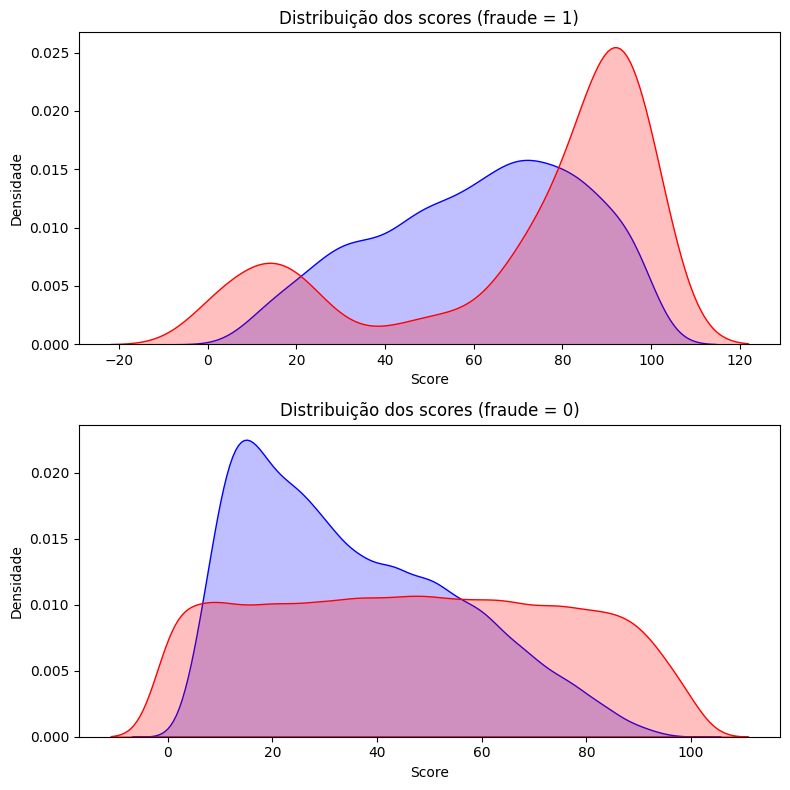

In [24]:
fig, ax = plt.subplots(2, 1, figsize=(8, 8))

# Access the axes directly
sns.kdeplot(
    data=X_test_evaluate[X_test_evaluate["fraude"] == 1],
    x="score_new_model",
    ax=ax[0],
    color="b",
    fill=True,
)
sns.kdeplot(
    data=X_test_evaluate[X_test_evaluate["fraude"] == 1],
    x="score_fraude_modelo",
    ax=ax[0],
    color="r",
    fill=True,
)

sns.kdeplot(
    data=X_test_evaluate[X_test_evaluate["fraude"] == 0],
    x="score_new_model",
    ax=ax[1],
    color="b",
    fill=True,
)
sns.kdeplot(
    data=X_test_evaluate[X_test_evaluate["fraude"] == 0],
    x="score_fraude_modelo",
    ax=ax[1],
    color="r",
    fill=True,
)

# Add titles and labels
ax[0].set_title("Distribuição dos scores (fraude = 1)")
ax[0].set_xlabel("Score")
ax[0].set_ylabel("Densidade")

ax[1].set_title("Distribuição dos scores (fraude = 0)")
ax[1].set_xlabel("Score")
ax[1].set_ylabel("Densidade")

plt.tight_layout()
plt.show()

Percebemos um comportamento mais homogêneo nas predições do novo modelo (em azul), classificando também em valores intermediários de score.

Vamos comparar diretamente o modelo nas métricas de negócio levantadas no notebook de entendimento do negócio. Vamos reaproveitar o código construído para achar o limiar ótimo que gere maior rendimento para a empresa. Agora aplicados unicamente aos dados de teste.

In [25]:
%pwd
%cd ..
from src.fraud_detection.utils.base_metrics import BaseMetrics


c:\Users\renne\Documents\Estudos Dados\Repositórios\ML\fraud-detection


c:\Users\renne\anaconda3\envs\fraud-detection\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [26]:
bm_old = BaseMetrics(X_test_evaluate, "score_fraude_modelo", "fraude", "valor_compra")

bm_old.find_best_threshold()
bm_old.show_all_metrics()

O limiar ótimo encontrado para a amostra é de: 72
Ganhos por transações aprovadas: R$ 80329.99
Prejuízos com transações fraudulentas aprovadas: R$ 25353.32
Receita gerada com limiar ótimo: R$ 54976.67
Taxa de pressão de entrada é de 5.123333333333333%
Taxa de aprovação total é de 73.37%
Taxa de declínio total é de 25.66%
A precisão do modelo é de 13.43%
A revocação do modelo é de 68.21%
A taxa de falsos positivos é de 23.64%


In [27]:
bm_new = BaseMetrics(X_test_evaluate, "score_new_model", "fraude", "valor_compra")

bm_new.find_best_threshold()
bm_new.show_all_metrics()

O limiar ótimo encontrado para a amostra é de: 65
Ganhos por transações aprovadas: R$ 95829.47
Prejuízos com transações fraudulentas aprovadas: R$ 34098.11
Receita gerada com limiar ótimo: R$ 61731.36
Taxa de pressão de entrada é de 5.123333333333333%
Taxa de aprovação total é de 87.82%
Taxa de declínio total é de 12.18%
A precisão do modelo é de 20.47%
A revocação do modelo é de 48.67%
A taxa de falsos positivos é de 10.21%


---
## Conclusão

Com o novo modelo percebemos as seguintes alterações na predição de fraudes:

- Melhoria da receita gerada para a amostra de **6754.69** para o intervalo da amostra.  
- Comportamento do modelo se tornou mais arriscado (limiar foi de 72 para 65), deixando de resgatar mais fraudes, porém permitindo aprovar mais transações legítimas. Este limiar no novo modelo traz um aumento de precisão de **7.04%**, enquanto a revocação diminui em **19.54%**.  
- Tal comportamento também foi refletido na diminuição de **13.43%** dos falsos positivos.  
- Sem considerar os limiares ótimos calculados, a métrica de log loss caiu de 16.1307 para 9.2392.  

Como dificuldades apresentadas na criação do modelo temos principalmente o desbalanceamento dos dados entre as classes, em que podemos seguir a experimentação ao aplicar técnicas de Oversampling para ps casos de fraude. Além disse o TargetEncoder talvez não seja a melhor alternativa para lidar com a grande cardinalidade dos valores de `categoria_produto`, se obtivessemos informações da hierarquia anterior esta poderia ter maior aplicabilidade ao modelo.

A anonimização das informações também torna arriscado lidarmos com casos de possíveis outliers, a ausência de semântica não nos permite identificar se valores extremos podem ser possíveis.

Considerando a melhoria da receita podemos concluir que o modelo possui um comportamento melhor para o negócio, porém a análise de fraudes em um cenário real é mais extensa e complexa, por exemplo, deveríamos levar em conta a experiência do usuário no que tange a lidar com o tratamento de uma transação fraudulenta, comparado a lidar com o declínio de transações, tais fatores e métricas podem gerar impacto nas reclamações e satisfações mesmo com uma métrica monetária vantajosa.